## 采用卷积神经网络对bitcoin 进行长期预测

<a target="_blank" href="https://colab.research.google.com/github/cecicxy/Virtual-Currency-Practise/blob/main/simplemodel/longtermprediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!wget https://raw.githubusercontent.com/cecicxy/Virtual-Currency-Practise/main/datasets/demodata.csv

In [3]:
## 数据导入
import pandas   as pd
data = pd.read_csv('./demodata.csv',index_col='date')
data.index = pd.to_datetime(data.index)
data

In [8]:
import numpy as np
newdata = data.replace(0,np.nan).fillna(method='ffill').replace(0,np.nan).dropna(axis=1)
newdata

In [10]:
valid = newdata[['open',	'high',	'low',	'close',	'CCI',
 'ADX',
 'STOCH',
 'RSI',
 'MOM',
 'MACD',
 'MACDSingal',
 'FearGreedIndex',
 'btcDominance',
'googlePrice',
 'METAPrice',
 'AMAZONPrice']]


In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
minmax= MinMaxScaler()
normdata = minmax.fit_transform(valid)
normdf = pd.DataFrame(normdata,columns=valid.columns,index=valid.index)


In [12]:
normdata.shape

(1345, 16)

<Axes: xlabel='date'>

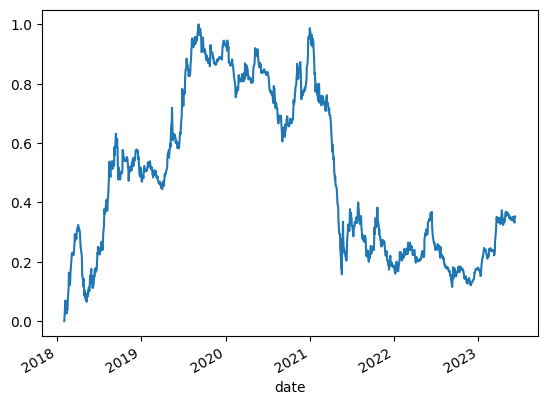

In [13]:
normdf.btcDominance.plot()

In [14]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [15]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [33]:
from tqdm  import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def train(model,dataloader,validataloader,device,epochNum=10,learningrate=1e-3,decay=0.02,patience=10,modelpath= 'checkpoint.pt'):
    print(model,dataloader,validataloader,device)
    loss_function = nn.MSELoss().to(device)
    # loss_function = CosineLoss(device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningrate,
                                      weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
  # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    early_stopping = EarlyStopping(patience=patience,path= modelpath, verbose=True)
    print(type(dataloader))
    batchsize = dataloader.batch_size
    for epoch in range(epochNum):
        model.train() # prep model for training
        for batch, (data, target) in tqdm(enumerate(dataloader,1),desc=f'epoch {epoch}:'):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            batchsize = output.size(0)
            output = output.view(output.size(0),-1).to(device)
            target = target.view(target.size(0),-1).to(device)
            # print(output.size())
            # calculate the loss
            loss = loss_function(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        model.eval() # prep model for evaluation
        for batch, (data, target)in tqdm(enumerate(validataloader,1),desc=f'epoch {epoch}: validate'):
            # if batch >=int(len(validataloader.dataset)/batchsize):
            #     break
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            output = output.view(output.size(0),-1).to(device)
            target = target.view(target.size(0),-1).to(device)
            loss = loss_function(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        print_msg = (f'epoch: [{epoch}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        scheduler.step()
      # load the last checkpoint with the best model
    model.load_state_dict(torch.load(modelpath))
    return  model, avg_train_losses, avg_valid_losses


In [42]:
## 构建CNN模型 卷积神经网络
import torch.nn as nn
from copy import deepcopy
class CNN(nn.Module):
    def __init__(self,inputsize,outputsize,window,predlen,device,hiddens=[128,64,32]):
        super(CNN,self).__init__()
        self.device = device
        self.input_size = inputsize
        self.seqlen = window
        self.pred_len = predlen
        self.output_size =outputsize
        self.hiddens = deepcopy(hiddens)
        hideC =8
        self.conv1 = nn.Sequential(
            # 输入[1,inputsize,window]
            nn.Conv2d(
                in_channels=1,    # 输入图片的通道
                out_channels=hideC,  # 输出图片的通道
                kernel_size=(int(window/12),int(inputsize/10)),    # 5x5的卷积核，相当于过滤器
                # stride=1,         # 卷积核在图上滑动，每隔一个扫一次
            ),
            # 经过卷积层 输出[16,inputsize,window] 传入池化层
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # 经过池化 输出[inputsize/2,window/2] 传入下一个卷积
        )
        outC= 4
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hideC,    # 同上
                out_channels=outC,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            # 经过卷积 输出[32, 14, 14] 传入池化层
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # 经过池化 输出[32,7,7] 传入输出层
            # ,nn.BatchNorm2d(outC)
        )
        self.linears = nn.ModuleList()
        ## 输出层
        c,t,w = self.get_convsize()
        self.hiddens.insert(0,c*t*w)
        self.hiddens.append(self.output_size*self.pred_len)
        for i in range(len(self.hiddens)-1):
            self.linears.append(nn.Linear(in_features=self.hiddens[i], out_features=self.hiddens[i+1]).to(self.device))

    def get_convsize(self):
        testinput= torch.ones((32,1,self.seqlen,self.input_size))
        testinput = self.conv1(testinput)
        testinput = self.conv2(testinput)
        b,c,t,w = testinput.size()
        return c,t,w

    def forward(self,x):
        b,t,w = x.size()
        x= x.view(b,1,t,w)
        x = self.conv1(x)
        x = self.conv2(x)
        b,c,t,w = x.size()
        x = x.view(b,-1,c*t*w)
        for i in range(len(self.hiddens)-1):
            x = self.linears[i](x)
        return x.view(b,self.pred_len,self.output_size)



In [125]:
import torch
device = torch.device('cuda',index=0)
from torch.utils.data import Dataset,DataLoader
def preparedataset(normdf,device,window=60,predlen=20):
    dataset = []
    for i in range(len(normdf)-window-predlen):
        dataset.append((torch.tensor(normdf.iloc[i:i+window].values).float().to(device),torch.tensor(normdf.iloc[i+window:i+window+predlen]['open'].values.reshape(-1,1)).float().to(device)))
    return dataset
seqlen = 80
prelen = 20
dataset = preparedataset(normdf,device,window=seqlen,predlen=prelen)
trainData = dataset[:int(len(dataset)*0.8)]
valiData = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
testData = dataset[int(len(dataset)*0.9):]

In [126]:
from torch.utils.data import DataLoader
batch_size= 32
trainLoader = DataLoader(trainData,batch_size=batch_size,shuffle=True)
valiLoader = DataLoader(valiData,batch_size=batch_size,shuffle=True)
testLoader = DataLoader(testData,batch_size=batch_size)

In [133]:
model = CNN(inputsize=trainData[0][0].size()[1],outputsize=1,window=trainData[0][0].size()[0],predlen=trainData[0][1].size()[0],device=device,hiddens=[128,64,32]).to(device)
# model.load_state_dict(torch.load('checkpoint.pt'))
model,losss,valilosss= train(model,trainLoader,valiLoader,device,epochNum=100,learningrate=0.01,decay=0.01,patience=10)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(6, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linears): ModuleList(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=20, bias=True)
  )
) <torch.utils.data.dataloader.DataLoader object at 0x7f48304fca90> <torch.utils.data.dataloader.DataLoader object at 0x7f48304fd750> cuda:0
<class 'torch.utils.data.dataloader.DataLoader'>


epoch 0:: 32it [00:00, 259.78it/s]
epoch 0: validate: 4it [00:00, 630.49it/s]


epoch: [0] train_loss: 0.10426 valid_loss: 0.01500
Validation loss decreased (inf --> 0.014997).  Saving model ...


epoch 1:: 32it [00:00, 265.08it/s]
epoch 1: validate: 4it [00:00, 649.32it/s]


epoch: [1] train_loss: 0.01460 valid_loss: 0.02725
EarlyStopping counter: 1 out of 10


epoch 2:: 32it [00:00, 278.76it/s]
epoch 2: validate: 4it [00:00, 683.56it/s]


epoch: [2] train_loss: 0.01435 valid_loss: 0.02614
EarlyStopping counter: 2 out of 10


epoch 3:: 32it [00:00, 288.10it/s]
epoch 3: validate: 4it [00:00, 684.48it/s]


epoch: [3] train_loss: 0.01476 valid_loss: 0.02973
EarlyStopping counter: 3 out of 10


epoch 4:: 32it [00:00, 294.24it/s]
epoch 4: validate: 4it [00:00, 643.54it/s]


epoch: [4] train_loss: 0.01249 valid_loss: 0.03122
EarlyStopping counter: 4 out of 10


epoch 5:: 32it [00:00, 290.53it/s]
epoch 5: validate: 4it [00:00, 659.61it/s]


epoch: [5] train_loss: 0.01113 valid_loss: 0.02535
EarlyStopping counter: 5 out of 10


epoch 6:: 32it [00:00, 310.87it/s]
epoch 6: validate: 4it [00:00, 628.83it/s]


epoch: [6] train_loss: 0.01083 valid_loss: 0.04734
EarlyStopping counter: 6 out of 10


epoch 7:: 32it [00:00, 276.02it/s]
epoch 7: validate: 4it [00:00, 694.42it/s]


epoch: [7] train_loss: 0.01197 valid_loss: 0.01026
Validation loss decreased (0.014997 --> 0.010259).  Saving model ...


epoch 8:: 32it [00:00, 259.65it/s]
epoch 8: validate: 4it [00:00, 614.78it/s]


epoch: [8] train_loss: 0.01040 valid_loss: 0.00669
Validation loss decreased (0.010259 --> 0.006689).  Saving model ...


epoch 9:: 32it [00:00, 241.94it/s]
epoch 9: validate: 4it [00:00, 713.26it/s]


epoch: [9] train_loss: 0.01198 valid_loss: 0.01828
EarlyStopping counter: 1 out of 10


epoch 10:: 32it [00:00, 286.00it/s]
epoch 10: validate: 4it [00:00, 706.47it/s]


epoch: [10] train_loss: 0.00882 valid_loss: 0.01950
EarlyStopping counter: 2 out of 10


epoch 11:: 32it [00:00, 272.30it/s]
epoch 11: validate: 4it [00:00, 601.18it/s]


epoch: [11] train_loss: 0.01266 valid_loss: 0.02327
EarlyStopping counter: 3 out of 10


epoch 12:: 32it [00:00, 329.76it/s]
epoch 12: validate: 4it [00:00, 864.45it/s]


epoch: [12] train_loss: 0.01016 valid_loss: 0.00682
EarlyStopping counter: 4 out of 10


epoch 13:: 32it [00:00, 361.92it/s]
epoch 13: validate: 4it [00:00, 681.28it/s]


epoch: [13] train_loss: 0.00649 valid_loss: 0.00647
Validation loss decreased (0.006689 --> 0.006467).  Saving model ...


epoch 14:: 32it [00:00, 350.14it/s]
epoch 14: validate: 4it [00:00, 684.09it/s]


epoch: [14] train_loss: 0.00867 valid_loss: 0.02900
EarlyStopping counter: 1 out of 10


epoch 15:: 32it [00:00, 391.20it/s]
epoch 15: validate: 4it [00:00, 702.62it/s]


epoch: [15] train_loss: 0.00887 valid_loss: 0.01629
EarlyStopping counter: 2 out of 10


epoch 16:: 32it [00:00, 359.77it/s]
epoch 16: validate: 4it [00:00, 655.10it/s]


epoch: [16] train_loss: 0.00698 valid_loss: 0.00496
Validation loss decreased (0.006467 --> 0.004959).  Saving model ...


epoch 17:: 32it [00:00, 343.19it/s]
epoch 17: validate: 4it [00:00, 548.33it/s]


epoch: [17] train_loss: 0.00668 valid_loss: 0.00945
EarlyStopping counter: 1 out of 10


epoch 18:: 32it [00:00, 376.44it/s]
epoch 18: validate: 4it [00:00, 848.15it/s]


epoch: [18] train_loss: 0.00657 valid_loss: 0.31609
EarlyStopping counter: 2 out of 10


epoch 19:: 32it [00:00, 394.90it/s]
epoch 19: validate: 4it [00:00, 801.28it/s]


epoch: [19] train_loss: 0.01634 valid_loss: 0.06546
EarlyStopping counter: 3 out of 10


epoch 20:: 32it [00:00, 375.24it/s]
epoch 20: validate: 4it [00:00, 432.90it/s]


epoch: [20] train_loss: 0.00983 valid_loss: 0.01319
EarlyStopping counter: 4 out of 10


epoch 21:: 32it [00:00, 378.43it/s]
epoch 21: validate: 4it [00:00, 661.38it/s]


epoch: [21] train_loss: 0.00796 valid_loss: 0.00986
EarlyStopping counter: 5 out of 10


epoch 22:: 32it [00:00, 363.34it/s]
epoch 22: validate: 4it [00:00, 798.80it/s]


epoch: [22] train_loss: 0.00773 valid_loss: 0.00467
Validation loss decreased (0.004959 --> 0.004672).  Saving model ...


epoch 23:: 32it [00:00, 384.74it/s]
epoch 23: validate: 4it [00:00, 625.55it/s]


epoch: [23] train_loss: 0.00682 valid_loss: 0.00548
EarlyStopping counter: 1 out of 10


epoch 24:: 32it [00:00, 383.32it/s]
epoch 24: validate: 4it [00:00, 674.05it/s]


epoch: [24] train_loss: 0.00843 valid_loss: 0.00305
Validation loss decreased (0.004672 --> 0.003049).  Saving model ...


epoch 25:: 32it [00:00, 384.11it/s]
epoch 25: validate: 4it [00:00, 671.30it/s]


epoch: [25] train_loss: 0.01279 valid_loss: 0.02362
EarlyStopping counter: 1 out of 10


epoch 26:: 32it [00:00, 377.35it/s]
epoch 26: validate: 4it [00:00, 657.03it/s]


epoch: [26] train_loss: 0.00788 valid_loss: 0.00535
EarlyStopping counter: 2 out of 10


epoch 27:: 32it [00:00, 354.95it/s]
epoch 27: validate: 4it [00:00, 741.57it/s]


epoch: [27] train_loss: 0.00653 valid_loss: 0.00497
EarlyStopping counter: 3 out of 10


epoch 28:: 32it [00:00, 397.43it/s]
epoch 28: validate: 4it [00:00, 697.19it/s]


epoch: [28] train_loss: 0.00846 valid_loss: 0.00523
EarlyStopping counter: 4 out of 10


epoch 29:: 32it [00:00, 385.75it/s]
epoch 29: validate: 4it [00:00, 790.22it/s]


epoch: [29] train_loss: 0.01187 valid_loss: 0.00983
EarlyStopping counter: 5 out of 10


epoch 30:: 32it [00:00, 406.93it/s]
epoch 30: validate: 4it [00:00, 696.50it/s]


epoch: [30] train_loss: 0.00723 valid_loss: 0.00808
EarlyStopping counter: 6 out of 10


epoch 31:: 32it [00:00, 386.20it/s]
epoch 31: validate: 4it [00:00, 573.23it/s]


epoch: [31] train_loss: 0.00739 valid_loss: 0.01283
EarlyStopping counter: 7 out of 10


epoch 32:: 32it [00:00, 393.08it/s]
epoch 32: validate: 4it [00:00, 850.43it/s]


epoch: [32] train_loss: 0.00555 valid_loss: 0.02195
EarlyStopping counter: 8 out of 10


epoch 33:: 32it [00:00, 362.46it/s]
epoch 33: validate: 4it [00:00, 680.01it/s]


epoch: [33] train_loss: 0.00749 valid_loss: 0.12645
EarlyStopping counter: 9 out of 10


epoch 34:: 32it [00:00, 335.28it/s]
epoch 34: validate: 4it [00:00, 646.30it/s]

epoch: [34] train_loss: 0.01557 valid_loss: 0.00773
EarlyStopping counter: 10 out of 10
Early stopping


In [134]:
def testLoss(model,testdataloader,device):
    loss_function = nn.MSELoss().to(device)
    batchsize = testdataloader.batch_size
    sum=0
    for batch, (data, target)in tqdm(enumerate(testdataloader,1),desc=f'test validate'):
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = output.view(output.size(0),-1)
        target = target.view(target.size(0),-1)
        # print(output.max())
        # print(output.min())
        # calculate the loss
        loss = loss_function(output, target)
        # record validation loss
        sum+=loss.item()
    return sum/batch

In [135]:
realLoss = testLoss(model,testLoader,device)
realLoss

test validate: 4it [00:00, 707.18it/s]


0.020527820772258565

In [137]:
def SingleTest(model,start,end,predlen,seqlen,dev):
    initdata = None
    for i in np.arange(end,start,-predlen)[::-1]:
        udata = torch.tensor(np.array(normdata[i-seqlen:i]).astype('float32').reshape(1,seqlen,-1)).to(dev)
        # print(udata.size())
        pred = model(udata)
        # print(pred.max())
        if initdata is not None:
            initdata= np.vstack([initdata,pred.data.cpu()[0].numpy()])
        else:
            initdata= pred.data.cpu()[0].numpy()
    return initdata

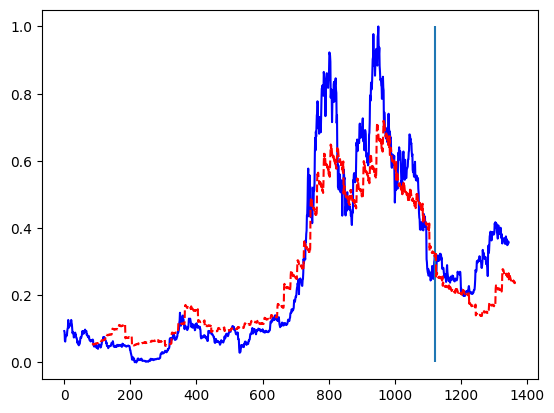

In [138]:
import matplotlib.pyplot as plt
start,end=  seqlen,int(len(normdata))
initdata = SingleTest(model,start,end,prelen,seqlen,device)
plt.plot(np.arange(len(normdata)),normdata[:,0],'b-')
plt.vlines(x=int(len(dataset)*0.9),ymin=0,ymax=1)
plt.plot(np.arange(end-len(initdata)+prelen,end+prelen,1),initdata,'r--')